In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import median_absolute_error, make_scorer

from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import RidgeCV, PassiveAggressiveRegressor, LinearRegression, TheilSenRegressor, HuberRegressor, RANSACRegressor, Lasso, ElasticNet, Lars, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, TweedieRegressor, PoissonRegressor, GammaRegressor, LassoLars
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

experiment = 'standard_scaling_no_keras'

import warnings
warnings.filterwarnings("ignore")

c:\Users\Adeniyi Babalola\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
train = pd.read_csv('train.csv')
artificial = pd.read_csv('Artificial_Crystals_Dataset.csv')
mineral = pd.read_csv('Mineral_Dataset_Supplementary_Info.csv')
test = pd.read_csv('test.csv')

train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [3]:
# Rename hardness in artifical dataset and drop columns not required
artificial.rename(columns={'Hardness (Mohs)': 'Hardness'}, inplace=True)
artificial.drop(['Formula', 'Crystal structure', 'Unnamed: 0'], axis=1, inplace=True)

artificial.head()

,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,4.5,167.0,23.907992,18.555556,5.000000,41.609136,11.693844,2.938889,1.711111,0.884444,0.477830,2.656444
1,4.0,14.0,1.740168,4.666667,1.333333,8.773227,11.614333,1.903333,1.310000,0.680000,0.825990,0.580056
2,2.5,102.0,8.511159,4.434783,3.304348,8.440584,13.176622,2.672609,1.379130,0.530870,0.713850,0.370050
3,5.5,78.0,8.109328,13.000000,5.333333,27.448814,11.826400,2.960000,1.625000,0.813333,0.488163,1.351555
4,6.5,164.0,19.921324,14.909091,5.090909,32.012361,11.255573,2.881818,1.640909,0.841818,0.483480,1.811029


In [4]:
# Drop unneeded columns
mineral.drop('Unnamed: 0', axis=1, inplace=True)

mineral.head()

,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,2.3,110.0,23.000000,36.666667,2.666667,82.598467,8.504133,2.146667,2.006667,1.253333,0.456803,7.666667
1,5.5,406.0,30.472136,9.902439,4.682927,19.813180,11.456151,2.700244,1.676829,0.868293,0.522909,0.743223
2,5.5,406.0,30.472464,10.410256,4.923077,20.931371,11.541405,2.753590,1.703846,0.894359,0.497498,0.781345
3,5.5,476.0,61.142136,11.609756,4.682927,23.659644,11.487395,2.763659,1.714634,0.848780,0.519474,1.491272
4,5.5,476.0,61.142464,12.205128,4.923077,24.975089,11.574251,2.820256,1.743590,0.873846,0.493887,1.567755


In [5]:
train.shape, artificial.shape, mineral.shape

((10407, 13), (52, 12), (622, 12))

In [6]:
# train = pd.concat([train, artificial, mineral], axis=0)
# train.shape

In [7]:
# Constants
TARGET = 'Hardness'

In [8]:
# Selecting numerical variables from the train dataset, excluding 'id' and TARGET
num_var = train.drop(['id', TARGET], axis=1).select_dtypes(include=np.number).columns
print(num_var)

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object')


In [9]:
len(num_var)

11

In [10]:
# # Combining train and test datasets for comparative analysis
# # 'Source' column is added to label data from each dataset
# df = pd.concat([
#     train[num_var].assign(Source='Train'), 
#     test[num_var].assign(Source='Test')
# ], axis=0, ignore_index=True)

In [11]:
# # Check for outliers
# def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
#     quartile1 = dataframe[col_name].quantile(q1)
#     quartile3 = dataframe[col_name].quantile(q3)
#     IQR = quartile3 - quartile1
#     up_limit = quartile3 + 1.5 * IQR
#     low_limit = quartile1 - 1.5 * IQR
#     print(f'Feature name: {col_name}')
#     print(f'Low Limit: {low_limit}')
#     print(f'Upper Limit: {up_limit}')
#     print()
#     return low_limit, up_limit


# def remove_outlier(dataframe, col_name):
#     """
#     Example Usage:
#     for col in num_cols:
#     new_df = remove_outlier(titanic, col)
#     """
#     low_limit, up_limit = outlier_thresholds(dataframe, col_name)
#     df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]    
#     return df_without_outliers

# def cap_outliers(dataframe, col_name):
#     low_limit, up_limit = outlier_thresholds(dataframe, col_name)

#     dataframe[col_name] = np.where(dataframe[col_name] > up_limit, up_limit, 
#                                    np.where(dataframe[col_name] < low_limit, low_limit, dataframe[col_name]))
#     return dataframe

# df_outliers = train.copy()
# df_outliers_test = test.copy()

# for col in num_var:
#     df_outliers = remove_outlier(df_outliers, col)
#     df_outliers_test = remove_outlier(df_outliers_test, col)

# df_outliers.columns

In [12]:
scaler = StandardScaler()

standard_scaler = scaler.fit_transform(train[num_var])
train_scaled = pd.DataFrame(standard_scaler, columns=num_var)

test_scaled = scaler.transform(test[num_var])
test_scaled = pd.DataFrame(test_scaled, columns=num_var)
# X = pd.concat([X[cat_features], train_scaled], axis=1)
train_scaled.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,-0.125176,-0.854598,-0.671863,0.366532,-0.649538,0.106370,0.472806,0.003480,-0.467381,0.043139,-0.629163
1,-0.125176,-0.434060,-0.671863,0.366532,-0.661596,0.782925,0.439960,-0.521272,-0.189615,-0.009986,-0.730874
2,-0.232265,-0.350946,-0.136912,1.524558,-0.144879,0.815215,0.657942,0.294432,-0.445159,-0.188197,-0.323591
3,-0.125176,-0.356625,-0.671863,0.366532,-0.664885,0.007237,0.120452,-0.547250,-0.045177,-0.064634,-0.693814
4,-0.053783,-0.307620,-0.519020,0.366532,-0.481317,0.629290,0.472806,-0.256298,-0.267389,-0.009717,-0.138479


In [13]:
# test_scaled.head()

# MODEL CROSS-VALIDATION

In [14]:
MLA = [
	# Trial Models
	MLPRegressor(random_state=5),
	TheilSenRegressor(random_state=5),
	HuberRegressor(),
	RANSACRegressor(random_state=5),
	Lasso(random_state=5),
	ElasticNet(random_state=5),
	Lars(random_state=5),
	LassoLars(random_state=5),
	OrthogonalMatchingPursuit(),
	BayesianRidge(),
	ARDRegression(),
    TweedieRegressor(power=1.5, alpha=0.5),
    PoissonRegressor(alpha=0.5),
    GammaRegressor(alpha=0.5),
    LassoLars(alpha=0.1, random_state=5),

	# GLM
	LinearRegression(),
	PassiveAggressiveRegressor(random_state=5),
	RidgeCV(),

	# Trees    
	DecisionTreeRegressor(random_state=5),
	ExtraTreeRegressor(random_state=5),

	XGBRegressor(random_state=5),
	LGBMRegressor(n_jobs=-1, random_state=5),
	CatBoostRegressor(random_state=5, verbose=False, early_stopping_rounds=100),
	
	# KNeighbors
	KNeighborsRegressor(),
	KNeighborsRegressor(n_neighbors=2),
	KNeighborsRegressor(n_neighbors=4),
	KNeighborsRegressor(n_neighbors=8),
	KNeighborsRegressor(n_neighbors=16),
	KNeighborsRegressor(n_neighbors=32),
	KNeighborsRegressor(n_neighbors=64),
	KNeighborsRegressor(n_neighbors=128),
	KNeighborsRegressor(n_neighbors=256),
	KNeighborsRegressor(n_neighbors=512),
	KNeighborsRegressor(n_neighbors=1024),

	# Ensemble Methods
	AdaBoostRegressor(random_state=5),
	BaggingRegressor(random_state=5),
	ExtraTreesRegressor(random_state=5),
	GradientBoostingRegressor(random_state=5),
	HistGradientBoostingRegressor(random_state=5),
	RandomForestRegressor(random_state=5),
    ]


# split dataset in cross-validation with splitter class
# cv_split could KFold, StratifiedKFold or RepeatedKFold depending on the problem
cv_split = KFold(n_splits=10, shuffle=True, random_state=5)
cv_split_trial = KFold(n_splits=3, shuffle=True, random_state=5) # For quick trials

In [15]:
# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# create table to compare MLA predictions
MLA_predict = {}

# index through MLA and save performance to table
row_index = 0
scoring = median_abs_error_scorer = make_scorer(median_absolute_error, greater_is_better=False)

for alg in MLA:

	# set name and parameters
	MLA_name = alg.__class__.__name__

	# Add suffix if name already exists
	suffix = 1
	original_MLA_name = MLA_name
	while MLA_compare['MLA Name'].str.contains(MLA_name).any():
		MLA_name = f"{original_MLA_name}_{suffix}"
		suffix += 1
		
	MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
	MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

	"""score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate"""

	cv_results = cross_validate(alg, train_scaled, train[TARGET], cv=cv_split, scoring=scoring, return_train_score=True)

	# Calculate mean time in seconds
	mean_fit_time = cv_results['fit_time'].mean()

	# Convert mean time to minutes and seconds
	minutes = int(mean_fit_time // 60)
	seconds = mean_fit_time % 60

	# Format the time and assign it
	MLA_compare.loc[row_index, 'MLA Time'] = f"{minutes} min {seconds:.2f} sec"
	MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean() * -1
	MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean() * -1
	#if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
	MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

	print(f'Done with {MLA_name}')
	row_index+=1

#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = True, inplace = True)
MLA_compare.to_csv(f'{experiment}_results.csv', index=False)
MLA_compare

Done with MLPRegressor
Done with TheilSenRegressor
Done with HuberRegressor
Done with RANSACRegressor
Done with Lasso
Done with ElasticNet
Done with Lars
Done with LassoLars
Done with OrthogonalMatchingPursuit
Done with BayesianRidge
Done with ARDRegression
Done with TweedieRegressor
Done with PoissonRegressor
Done with GammaRegressor
Done with LassoLars_1
Done with LinearRegression
Done with PassiveAggressiveRegressor
Done with RidgeCV
Done with DecisionTreeRegressor
Done with ExtraTreeRegressor
Done with XGBRegressor
Done with LGBMRegressor
Done with CatBoostRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor_1
Done with KNeighborsRegressor_2
Done with KNeighborsRegressor_3
Done with KNeighborsRegressor_4
Done with KNeighborsRegressor_5
Done with KNeighborsRegressor_6
Done with KNeighborsRegressor_7
Done with KNeighborsRegressor_8
Done with KNeighborsRegressor_9
Done with KNeighborsRegressor_10
Done with AdaBoostRegressor
Done with BaggingRegressor
Done with ExtraTr

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",0.540787,0.645379,0.09513,0 min 0.22 sec
36,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",-0.0,0.6459,0.079542,0 min 3.34 sec
38,HistGradientBoostingRegressor,"{'categorical_features': None, 'early_stopping...",0.539281,0.650216,0.106933,0 min 1.25 sec
39,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.2395,0.65555,0.081932,0 min 9.71 sec
22,CatBoostRegressor,"{'loss_function': 'RMSE', 'verbose': False, 'r...",0.503796,0.656515,0.079275,0 min 5.39 sec
20,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",0.351468,0.672582,0.105341,0 min 0.76 sec
35,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",0.25,0.683,0.10632,0 min 0.80 sec
37,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.674934,0.70176,0.119822,0 min 1.79 sec
27,KNeighborsRegressor_4,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.653281,0.704062,0.084899,0 min 0.02 sec
26,KNeighborsRegressor_3,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.61875,0.704375,0.08218,0 min 0.02 sec


Text(0, 0.5, 'Algorithm')

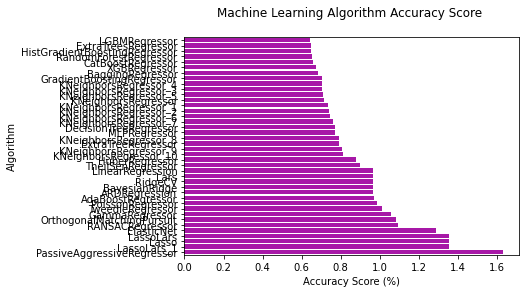

In [16]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

# ENSEMBLE CROSS-VALIDATION

In [17]:
# Hill Climbing inspired by code from Kaggle
def hill_climbing(x, y):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = median_absolute_error(y, x[col])

    # Sorting the model scores in ascending order
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = False)}

    # Sort oof_df
    x = x[list(scores.keys())]

    # Initialize weights
    weights = {col: 1 if i == 0 else 0 for i, col in enumerate(x.columns)}

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [median_absolute_error(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = median_absolute_error(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = median_absolute_error(y, potential_ensemble)
                if cv_score < potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            # Update weights
            weights = {col: (1 - wgt_best) * weights[col] if col != k_best else wgt_best for col in weights}
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred = current_best_ensemble
    
    return hill_ens_pred, weights

In [18]:
def create_submission_file(ids, predictions, filename):
    submission = pd.DataFrame({'id': ids, 'Hardness': predictions})
    submission.to_csv(filename, index=False)

In [19]:
hill_climb_scores = []
hill_climb_weights = []

for i, (train_index, test_index) in enumerate(cv_split.split(train_scaled, train[TARGET])):
    X_train, X_test = train_scaled.iloc[train_index], train_scaled.iloc[test_index]
    y_train, y_test = train[TARGET].iloc[train_index], train[TARGET].iloc[test_index]

    print(f'Fold {i+1}')
    
    MLA_cv_train_preds = []
    MLA_cv_preds = []
    MLA_cv_preds_dict = {}
    MLA_names = []
    
    suffix = 1
    for alg in MLA:
        MLA_name = alg.__class__.__name__

        # Add suffix if name already exists

        original_MLA_name = MLA_name
        if MLA_name in MLA_names:
        # while MLA_cv_preds.str.contains(MLA_name).any():
            MLA_name = f"{original_MLA_name}_{suffix}"
            suffix += 1
            
        predictor = alg.fit(X_train, y_train)
        pred_train_result = predictor.predict(X_train)
        pred_result = predictor.predict(X_test)

        MLA_cv_train_preds.append(pred_train_result)
        MLA_cv_preds.append(pred_result)
        MLA_cv_preds_dict[MLA_name] = pred_result
        MLA_names.append(MLA_name)

    ##################
    ### Hill Climb ###
    ##################
    hill_climb_pred, hill_climb_weight = hill_climbing(pd.DataFrame(MLA_cv_preds_dict), y_test)
    hill_climb_score = median_absolute_error(y_test, hill_climb_pred)
    hill_climb_scores.append(hill_climb_score)
    hill_climb_weights.append(hill_climb_weight)
    print(f'The Fold {i+1} Hill Climb is {hill_climb_score}')
    print(f'The Fold {i+1} weight is {hill_climb_weight}')
    print()

print()
print(f'The Hill Climbing CV score is ==> {np.mean(hill_climb_scores)}')
print(f'The Hill Climbing weights are ==> {hill_climb_weights}')

Fold 1
The Fold 1 Hill Climb is 0.5778263420127479
The Fold 1 weight is {'RandomForestRegressor': 1.102387217680431, 'CatBoostRegressor': 0.0, 'XGBRegressor': 0.010198959902010408, 'ExtraTreesRegressor': -0.009999999999999539, 'HistGradientBoostingRegressor': 0.0, 'LGBMRegressor': 0.0, 'KNeighborsRegressor': 4.44089209850062e-16, 'BaggingRegressor': 4.4408920985006183e-16, 'GradientBoostingRegressor': 0.0, 'KNeighborsRegressor_3': -0.010098989999999522, 'KNeighborsRegressor_6': 0.010201000000000427, 'KNeighborsRegressor_4': 0.0, 'KNeighborsRegressor_5': 0.0, 'KNeighborsRegressor_2': 4.440892098500622e-16, 'KNeighborsRegressor_7': 0.0, 'KNeighborsRegressor_8': -0.030290910908969116, 'MLPRegressor': 0.0, 'KNeighborsRegressor_9': 0.0, 'DecisionTreeRegressor': 4.440892098500624e-16, 'ExtraTreeRegressor': 0.010199979900000418, 'KNeighborsRegressor_11': 0.0, 'KNeighborsRegressor_10': -0.01009999999999953, 'HuberRegressor': 0.0, 'TheilSenRegressor': 0.0, 'Lars': 0.0, 'LinearRegression': 0.0, 

In [20]:
# Get average weights for the models from all the folds

average_values = {}

for model in hill_climb_weights:
    for key, value in model.items():
        if key in average_values:
            average_values[key] += value
        else:
            average_values[key] = value

num_models = len(hill_climb_weights)
average_values = {k: v / num_models for k, v in average_values.items()}

# Ensure the new weights sum up to 1
sum = 0

for k, v in average_values.items():
    sum += v

average_values, sum, len(average_values)

({'RandomForestRegressor': 0.2159371131195949,
  'CatBoostRegressor': -0.001979801999999816,
  'XGBRegressor': 0.038101870379980425,
  'ExtraTreesRegressor': 0.3957781596905707,
  'HistGradientBoostingRegressor': 0.20117658054506643,
  'LGBMRegressor': 0.2674014947129317,
  'KNeighborsRegressor': -0.006929999999999867,
  'BaggingRegressor': 0.0011474812000002855,
  'GradientBoostingRegressor': 0.0010000000000000891,
  'KNeighborsRegressor_3': -0.006900398999999863,
  'KNeighborsRegressor_6': -0.005302299999999866,
  'KNeighborsRegressor_4': 4.44089209850062e-17,
  'KNeighborsRegressor_5': 0.0,
  'KNeighborsRegressor_2': 0.029017006419200176,
  'KNeighborsRegressor_7': -0.00493999999999989,
  'KNeighborsRegressor_8': -0.004068487140896819,
  'MLPRegressor': 0.003029390010500132,
  'KNeighborsRegressor_9': 4.440892098500624e-17,
  'DecisionTreeRegressor': 0.027825601977404572,
  'ExtraTreeRegressor': 0.004009897990000261,
  'KNeighborsRegressor_11': 0.0,
  'KNeighborsRegressor_10': 0.005

In [21]:
# Create an ordered dictionary based on the order of models in MLA
ordered_average_values = {}
final_mlas = []

for model_name in MLA_names:        
    if model_name in average_values:
        ordered_average_values[model_name] = average_values[model_name]
    else:
        # Handle case where a model might not be in average_values
        ordered_average_values[model_name] = None

# Now ordered_average_values has the averages in the same order as MLA
ordered_average_values

{'MLPRegressor': 0.003029390010500132,
 'TheilSenRegressor': 0.0010000000000000453,
 'HuberRegressor': -0.015971709599999946,
 'RANSACRegressor': 0.009598411712835143,
 'Lasso': -0.06331612676504578,
 'ElasticNet': -0.032495567850751736,
 'Lars': 0.0,
 'LassoLars': 1.3322676295501858e-16,
 'OrthogonalMatchingPursuit': -0.015603991763163955,
 'BayesianRidge': 0.0,
 'ARDRegression': 0.0,
 'TweedieRegressor': 4.4408920985006184e-17,
 'PoissonRegressor': -0.028664063999999857,
 'GammaRegressor': 4.44089209850062e-17,
 'LassoLars_1': 1.3322676295501866e-16,
 'LinearRegression': 0.0,
 'PassiveAggressiveRegressor': -0.007219927647247594,
 'RidgeCV': 0.0,
 'DecisionTreeRegressor': 0.027825601977404572,
 'ExtraTreeRegressor': 0.004009897990000261,
 'XGBRegressor': 0.038101870379980425,
 'LGBMRegressor': 0.2674014947129317,
 'CatBoostRegressor': -0.001979801999999816,
 'KNeighborsRegressor': -0.006929999999999867,
 'KNeighborsRegressor_2': 0.029017006419200176,
 'KNeighborsRegressor_3': -0.00690

In [22]:
# Get the ordered weights values as a list to be used for final submission
hill_climb_final_weights = []

for value in ordered_average_values.values():
    hill_climb_final_weights.append(value)

hill_climb_final_weights

[0.003029390010500132,
 0.0010000000000000453,
 -0.015971709599999946,
 0.009598411712835143,
 -0.06331612676504578,
 -0.032495567850751736,
 0.0,
 1.3322676295501858e-16,
 -0.015603991763163955,
 0.0,
 0.0,
 4.4408920985006184e-17,
 -0.028664063999999857,
 4.44089209850062e-17,
 1.3322676295501866e-16,
 0.0,
 -0.007219927647247594,
 0.0,
 0.027825601977404572,
 0.004009897990000261,
 0.038101870379980425,
 0.2674014947129317,
 -0.001979801999999816,
 -0.006929999999999867,
 0.029017006419200176,
 -0.006900398999999863,
 4.44089209850062e-17,
 0.0,
 -0.005302299999999866,
 -0.00493999999999989,
 -0.004068487140896819,
 4.440892098500624e-17,
 0.005410330941176221,
 0.0,
 -0.0070409629321564375,
 0.0011474812000002855,
 0.3957781596905707,
 0.0010000000000000891,
 0.20117658054506643,
 0.2159371131195949]

In [23]:
test_predictions = []
# Make predictions on test set
for alg in MLA:
        MLA_name = alg.__class__.__name__
                
        predictor = alg.fit(train_scaled, train[TARGET])
        pred_result = predictor.predict(test_scaled)

        test_predictions.append(pred_result)
        print(f'Done with {MLA_name}')

Done with MLPRegressor
Done with TheilSenRegressor
Done with HuberRegressor
Done with RANSACRegressor
Done with Lasso
Done with ElasticNet
Done with Lars
Done with LassoLars
Done with OrthogonalMatchingPursuit
Done with BayesianRidge
Done with ARDRegression
Done with TweedieRegressor
Done with PoissonRegressor
Done with GammaRegressor
Done with LassoLars
Done with LinearRegression
Done with PassiveAggressiveRegressor
Done with RidgeCV
Done with DecisionTreeRegressor
Done with ExtraTreeRegressor
Done with XGBRegressor
Done with LGBMRegressor
Done with CatBoostRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with AdaBoostRegressor
Done with BaggingRegressor
Done with ExtraTreesRegressor
Done with 

In [24]:
# Double check that the weights and predictions are the same length
len(test_predictions), len(hill_climb_final_weights)

(40, 40)

In [25]:
weighted_avg_predictions = np.average(test_predictions, axis=0, weights=hill_climb_final_weights)
create_submission_file(test['id'], weighted_avg_predictions, f'submission_{experiment}.csv')